<a href="https://colab.research.google.com/github/marcochisci/Anomaly_detection/blob/main/10min_1day_AnomalyDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Airquino table Data
Average data values (every 10 minutes) of a day (the 10th of July)

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC
Dates,,,,,,,,,,
2021-07-10 00:00:00,298.142857,1.000000,410.857143,34.572857,21.742857,3.714286,495.714286,225.714286,210.714286,340.714286
2021-07-10 00:10:00,295.833333,1.000000,410.166667,34.373333,21.516667,3.000000,504.000000,224.333333,210.500000,337.833333
2021-07-10 00:20:00,294.000000,1.000000,410.285714,34.170000,21.357143,3.428571,509.857143,222.428571,210.857143,337.285714
2021-07-10 00:30:00,293.571429,0.857143,413.428571,34.021429,21.114286,3.428571,520.000000,227.000000,211.714286,337.857143
2021-07-10 00:40:00,295.200000,1.000000,413.400000,33.876000,20.940000,3.600000,528.200000,242.800000,212.600000,340.600000
...,...,...,...,...,...,...,...,...,...,...
2021-07-10 23:20:00,364.285714,3.285714,405.428571,35.588571,22.300000,7.857143,650.000000,239.142857,234.857143,346.714286
2021-07-10 23:30:00,353.833333,2.000000,400.833333,35.540000,22.566667,5.666667,646.666667,235.166667,236.000000,344.833333
2021-07-10 23:40:00,354.857143,2.000000,404.857143,35.608571,22.728571,6.000000,640.857143,243.428571,237.285714,344.857143


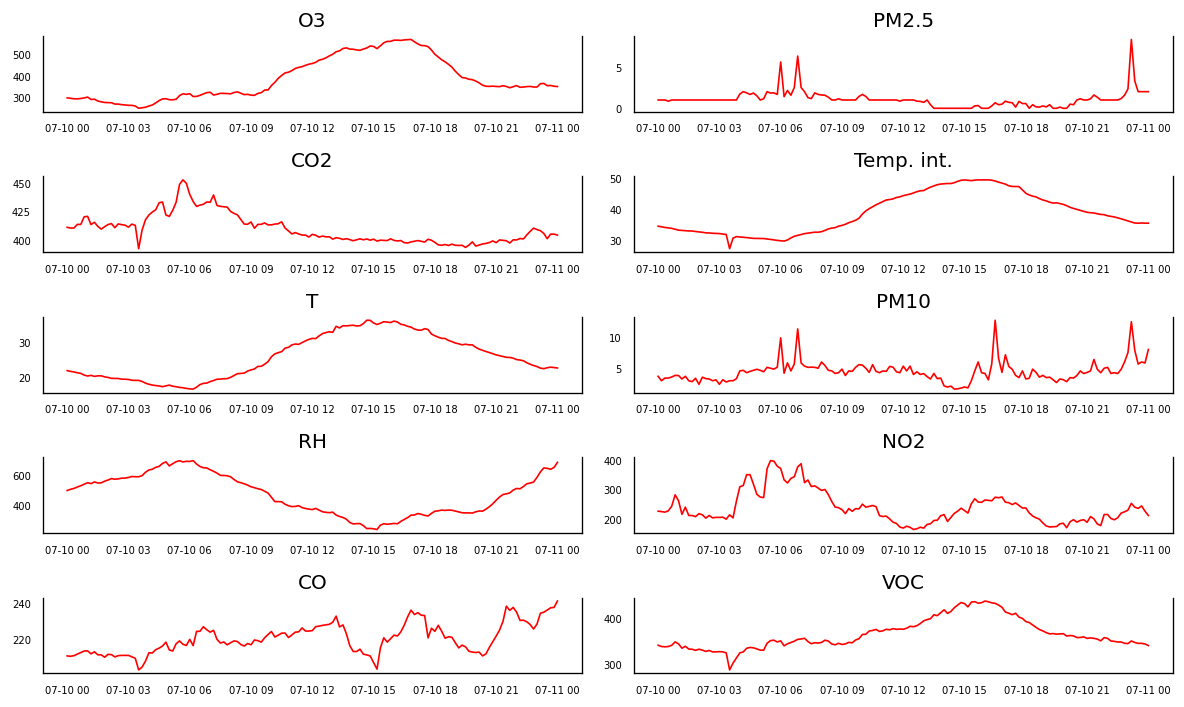

In [3]:
import pandas as pd
import psycopg2
import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import numpy as np
%matplotlib inline


conn = psycopg2.connect(host='playground.magentalab.it', port='55432', database='airqino', user='datareader', password='homntLZnlhQd9prtVA9SFezQek')

query=""" select time_bucket('10 minutes', c."Dates" ) as "bucket", avg(c."O3") as "O3" ,  avg(c."PM2.5") as "PM2.5", avg(c."CO2") as "CO2",
 avg(c."Temp. int.") as "Temp. int.",  avg(c."T") as "T",  avg(c."PM10") as "PM10", avg(c."RH") as "RH", avg(c."NO2") as 
 "NO2", avg(c."CO") as "CO", avg(c."VOC") as "VOC"
from (select * from crosstab(
  'select sd.data_acquired as timestamp, s.sensor_type ,  sd.float_value as value 
from station_data sd join sensor s on s.id = sd.sensor_id
where sd.data_acquired >= to_timestamp(''2021-07-10 00:00:00'', ''YYYY-mm-dd HH24:MI:SS'')
 and sd.data_acquired <= to_timestamp(''2021-07-11 00:00:00'', ''YYYY-mm-dd HH24:MI:SS'')
and sd.station_id = 23284701 order by sd.data_acquired asc, 1'
 , $$VALUES ('O3'::varchar), ('PM2.5'::varchar), ('CO2'::varchar), ('Temp. int.'::varchar), ('T'::varchar)
 , ('PM10'::varchar), ('RH'::varchar), ('NO2'::varchar), ('CO'::varchar), ('VOC'::varchar)$$
) AS value ("Dates" timestamp, "O3" float, "PM2.5" float, "CO2" float, "Temp. int." float, "T" float, "PM10" float,
"RH" float, "NO2" float, "CO" float, "VOC" float))  c 
group by bucket
order by bucket asc;
 """
df = pd.read_sql(query, conn)
df= df.rename(columns={'bucket': 'Dates'})
df=df.set_index('Dates')
#fix temp int
df['Temp. int.'] = df['Temp. int.'].div(100)
df['T'] = df['T'].div(10)

display(df)

# Plot
fig, axes = plt.subplots(nrows=5, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

# Testing stationarity 

In [7]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(ts_data, column='', signif=0.05, series=False):
    if series:
        adf_test = adfuller(ts_data, autolag='AIC')
    else:
        adf_test = adfuller(ts_data[column], autolag='AIC')
    p_value = adf_test[1]                   
    if p_value <= signif:
        test_result = "Stationary"
    else:
        test_result = "Non-Stationary"
    return test_result

adf_test_results = {
    col: test_stationarity(df, col)
    for col in df.columns
}
adf_test_results     

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


{'CO': 'Stationary',
 'CO2': 'Stationary',
 'NO2': 'Stationary',
 'O3': 'Stationary',
 'PM10': 'Stationary',
 'PM2.5': 'Stationary',
 'RH': 'Stationary',
 'T': 'Stationary',
 'Temp. int.': 'Stationary',
 'VOC': 'Stationary'}

Converting to stationary with differencing

In [4]:
#before the first differencing
df_copy= df.copy()

In [6]:
def differencing(data, column, order):
    differenced_data = data[column].diff(order)
    differenced_data.fillna(differenced_data.mean(), inplace=True)
    return differenced_data
for col in df.columns:
    df[col] = differencing(df, col, 1)

Test for stationarity now

# VAR model

Finding the best lag for VAR model (if the max_lag value is too high the model may not work)

In [8]:
from statsmodels.tsa.api import VAR
max_lag = 6
var_model = VAR(df)
# select the best lag order
lag_results = var_model.select_order(max_lag)
selected_lag = lag_results.aic
print(selected_lag)

6


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  % freq, ValueWarning)


Finding anomalies

In [9]:
import numpy as np
import scipy as sp

#mahalanobis distance
def mahalanobis(x=None, data=None, cov=None):
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = sp.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()
  
#0 means that is it not an anomaly
def find_anomalies(errors):
    threshold = np.mean(errors) + np.std(errors)
    predictions = (errors >= threshold).astype(int)
    return predictions, threshold
var = VAR(df)
var_fitresults = var.fit(selected_lag)
var_fit_df=pd.DataFrame(var_fitresults.fittedvalues, index=df_copy.index[-(len(df_copy)-selected_lag):], columns=df.columns)
errors = mahalanobis(x=var_fit_df, data= df)
errors_df=pd.DataFrame(errors, index=df_copy.index[-(len(df_copy)-selected_lag):])
predictions, threshold = find_anomalies(errors_df)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  % freq, ValueWarning)


In [10]:
data = df_copy.iloc[selected_lag:, :]
data['Predictions'] = predictions.values
data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Predictions
Dates,,,,,,,,,,,
2021-07-10 01:00:00,301.833333,1.000000,420.500000,33.298333,20.183333,3.833333,549.166667,260.833333,213.500000,343.666667,0
2021-07-10 01:10:00,290.714286,1.000000,413.285714,33.204286,20.371429,3.285714,542.714286,215.000000,211.857143,334.142857,0
2021-07-10 01:20:00,292.000000,1.000000,415.285714,33.090000,20.085714,3.714286,554.142857,239.428571,213.000000,338.428571,0
2021-07-10 01:30:00,283.666667,1.000000,411.666667,33.041667,20.233333,3.000000,546.833333,211.166667,211.333333,332.333333,0
2021-07-10 01:40:00,280.000000,1.000000,409.285714,33.022857,20.242857,2.857143,548.142857,211.000000,211.285714,331.857143,0
...,...,...,...,...,...,...,...,...,...,...,...
2021-07-10 23:20:00,364.285714,3.285714,405.428571,35.588571,22.300000,7.857143,650.000000,239.142857,234.857143,346.714286,1
2021-07-10 23:30:00,353.833333,2.000000,400.833333,35.540000,22.566667,5.666667,646.666667,235.166667,236.000000,344.833333,1
2021-07-10 23:40:00,354.857143,2.000000,404.857143,35.608571,22.728571,6.000000,640.857143,243.428571,237.285714,344.857143,0


In [11]:
data['Predictions'].value_counts()

0    125
1     14
Name: Predictions, dtype: int64

# Showing the anomalies found with Mahalanobis distance

The anomaly is shown with the 3 previous values, all the following anomalous values and the following 2 non-anomalous values

> The first anomaly is always the 4-th row



Diplay all the anomalies

In [44]:
index_no = data.columns.get_loc('Predictions')
i=0
while(i<len(data)):
  if(data.iloc[[i],[index_no]].values == 1):
    j=i+1
    while(data.iloc[[j],[index_no]].values == 1):
      j=j+1
    for s in range(i,j):
      d=0
      for col in df.columns:
        dis=float(data.iloc[[s],[d]].values-data.iloc[[s-1],[d]].values)
        print(col+':'+str(dis))
        d=d+1
      print ('*' * 20)
    if(i-3<0):
      tmp=data.iloc[i: j + 2]
      display(tmp)
    if(j+2>len(results_pred)):
      tmp=data_res.iloc[i: j + 2]
      display(tmp)
    else:
      tmp=data.iloc[i - 3 : j + 2]
      display(tmp)
    i=j
  else:
    i=i+1    

O3:2.5238095238095184
PM2.5:0.0
CO2:16.428571428571445
Temp. int.:3.3738095238095234
T:-0.3190476190476197
PM10:0.0
RH:7.476190476190482
NO2:-10.333333333333343
CO:1.5714285714285836
VOC:14.90476190476187
********************
O3:2.309523809523796
PM2.5:0.0
CO2:9.071428571428555
Temp. int.:0.5211904761904762
T:-0.480952380952381
PM10:0.3333333333333335
RH:23.19047619047626
NO2:56.833333333333314
CO:3.261904761904759
VOC:11.26190476190476
********************


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Predictions
Dates,,,,,,,,,,,
2021-07-10 03:10:00,263.666667,1.000000,413.666667,32.033333,18.966667,3.166667,591.333333,205.333333,210.166667,326.166667,0
2021-07-10 03:20:00,260.800000,1.000000,412.600000,31.904000,18.920000,2.800000,589.800000,198.600000,209.400000,324.000000,0
2021-07-10 03:30:00,250.333333,1.000000,392.000000,27.333333,18.933333,3.000000,589.666667,213.333333,203.000000,286.666667,0
2021-07-10 03:40:00,252.857143,1.000000,408.428571,30.707143,18.614286,3.000000,597.142857,203.000000,204.571429,301.571429,1
2021-07-10 03:50:00,255.166667,1.000000,417.500000,31.228333,18.133333,3.333333,620.333333,259.833333,207.833333,312.833333,1
2021-07-10 04:00:00,260.714286,1.714286,421.714286,31.098571,17.814286,4.571429,635.714286,308.714286,212.428571,324.000000,0
2021-07-10 04:10:00,265.333333,2.000000,424.333333,31.015000,17.566667,4.666667,641.000000,312.666667,212.333333,326.000000,0


O3:16.47619047619048
PM2.5:-0.16666666666666674
CO2:15.666666666666686
Temp. int.:-0.1385714285714279
T:-0.20000000000000284
PM10:-0.14285714285714324
RH:6.571428571428555
NO2:27.452380952380963
CO:1.5714285714285836
VOC:5.833333333333314
********************


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Predictions
Dates,,,,,,,,,,,
2021-07-10 05:00:00,289.666667,1.000000,420.500000,30.638333,17.566667,4.666667,663.500000,273.666667,214.000000,329.833333,0
2021-07-10 05:10:00,289.142857,1.142857,425.857143,30.600000,17.242857,4.428571,679.000000,271.714286,213.428571,329.857143,0
2021-07-10 05:20:00,291.857143,2.000000,433.000000,30.458571,17.100000,5.142857,692.428571,369.714286,217.428571,345.000000,0
2021-07-10 05:30:00,308.333333,1.833333,448.666667,30.320000,16.900000,5.000000,699.000000,397.166667,219.000000,350.833333,1
2021-07-10 05:40:00,316.714286,1.857143,452.714286,30.170000,16.800000,4.857143,690.857143,395.428571,217.142857,351.714286,0
2021-07-10 05:50:00,314.166667,1.666667,449.666667,29.995000,16.616667,5.166667,695.166667,378.166667,216.500000,347.833333,0


O3:-13.085714285714289
PM2.5:-4.171428571428571
CO2:-6.25714285714281
Temp. int.:-0.10428571428571587
T:-0.06571428571428939
PM10:-5.6571428571428575
RH:5.742857142857133
NO2:-38.571428571428555
CO:-3.4571428571428555
VOC:-10.8857142857143
********************
O3:0.5142857142857338
PM2.5:0.7428571428571429
CO2:-4.314285714285745
Temp. int.:0.35857142857142676
T:0.5514285714285734
PM10:1.6571428571428566
RH:-23.31428571428569
NO2:-10.571428571428555
CO:7.885714285714272
VOC:4.4571428571428555
********************
O3:5.0
PM2.5:-0.5714285714285714
CO2:1.1428571428571672
Temp. int.:0.6699999999999982
T:0.7428571428571438
PM10:-1.2857142857142856
RH:-16.57142857142867
NO2:15.571428571428555
CO:0.0
VOC:2.8571428571428896
********************


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Predictions
Dates,,,,,,,,,,,
2021-07-10 05:40:00,316.714286,1.857143,452.714286,30.170000,16.800000,4.857143,690.857143,395.428571,217.142857,351.714286,0
2021-07-10 05:50:00,314.166667,1.666667,449.666667,29.995000,16.616667,5.166667,695.166667,378.166667,216.500000,347.833333,0
2021-07-10 06:00:00,317.285714,5.571429,439.857143,29.884286,16.485714,9.857143,693.857143,370.571429,219.857143,350.285714,0
2021-07-10 06:10:00,304.200000,1.400000,433.600000,29.780000,16.420000,4.200000,699.600000,332.000000,216.400000,339.400000,1
2021-07-10 06:20:00,304.714286,2.142857,429.285714,30.138571,16.971429,5.857143,676.285714,321.428571,224.285714,343.857143,1
2021-07-10 06:30:00,309.714286,1.571429,430.428571,30.808571,17.714286,4.571429,659.714286,337.000000,224.285714,346.714286,1
2021-07-10 06:40:00,315.833333,2.500000,431.166667,31.318333,18.066667,5.666667,651.333333,342.666667,226.833333,349.500000,0
2021-07-10 06:50:00,322.142857,6.285714,433.142857,31.624286,18.157143,11.285714,649.571429,376.000000,225.142857,353.571429,0


O3:1.6904761904761472
PM2.5:-3.7857142857142856
CO2:-0.14285714285716722
Temp. int.:0.2607142857142861
T:0.42619047619047734
PM10:-5.452380952380953
RH:-12.238095238095184
NO2:10.666666666666686
CO:-1.309523809523796
VOC:0.7619047619047592
********************
O3:-12.833333333333314
PM2.5:-0.5
CO2:6.333333333333314
Temp. int.:0.29833333333333556
T:0.29999999999999716
PM10:-0.5
RH:-10.666666666666742
NO2:-64.16666666666669
CO:1.0
VOC:1.6666666666666856
********************
O3:3.571428571428555
PM2.5:-0.7142857142857142
CO2:-9.190476190476147
Temp. int.:0.15952380952380452
T:0.3738095238095269
PM10:-0.1904761904761898
RH:-12.095238095238074
NO2:8.928571428571445
CO:-4.976190476190482
VOC:-7.285714285714278
********************


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Predictions
Dates,,,,,,,,,,,
2021-07-10 06:30:00,309.714286,1.571429,430.428571,30.808571,17.714286,4.571429,659.714286,337.000000,224.285714,346.714286,1
2021-07-10 06:40:00,315.833333,2.500000,431.166667,31.318333,18.066667,5.666667,651.333333,342.666667,226.833333,349.500000,0
2021-07-10 06:50:00,322.142857,6.285714,433.142857,31.624286,18.157143,11.285714,649.571429,376.000000,225.142857,353.571429,0
2021-07-10 07:00:00,323.833333,2.500000,433.000000,31.885000,18.583333,5.833333,637.333333,386.666667,223.833333,354.333333,1
2021-07-10 07:10:00,311.000000,2.000000,439.333333,32.183333,18.883333,5.333333,626.666667,322.500000,224.833333,356.000000,1
2021-07-10 07:20:00,314.571429,1.285714,430.142857,32.342857,19.257143,5.142857,614.571429,331.428571,219.857143,348.714286,1
2021-07-10 07:30:00,319.000000,1.166667,429.333333,32.486667,19.300000,5.166667,599.000000,309.333333,217.833333,344.000000,0
2021-07-10 07:40:00,318.428571,1.857143,429.000000,32.638571,19.400000,5.142857,598.428571,311.571429,218.428571,346.142857,0


O3:4.214285714285666
PM2.5:-0.5714285714285714
CO2:-0.5238095238095184
Temp. int.:0.49238095238094814
T:-0.48571428571428044
PM10:-0.38095238095238093
RH:-9.09523809523813
NO2:2.333333333333343
CO:-5.952380952380935
VOC:2.0238095238095184
********************


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Predictions
Dates,,,,,,,,,,,
2021-07-10 12:50:00,490.500000,0.833333,402.500000,45.970000,32.933333,4.000000,344.500000,171.333333,228.166667,388.166667,0
2021-07-10 13:00:00,498.000000,0.714286,400.428571,46.030000,32.757143,4.142857,348.000000,168.285714,229.285714,394.142857,0
2021-07-10 13:10:00,509.500000,1.000000,401.666667,46.633333,34.500000,3.666667,327.666667,180.666667,232.666667,396.833333,0
2021-07-10 13:20:00,513.714286,0.428571,401.142857,47.125714,34.014286,3.285714,318.571429,183.000000,226.714286,398.857143,1
2021-07-10 13:30:00,524.333333,0.000000,400.166667,47.545000,34.666667,4.166667,311.333333,194.166667,227.833333,407.500000,0
2021-07-10 13:40:00,527.166667,0.000000,400.833333,47.920000,34.616667,3.333333,299.833333,195.000000,223.000000,405.500000,0


O3:1.1904761904762609
PM2.5:-0.23809523809523808
CO2:-0.3333333333333144
Temp. int.:-0.36214285714284955
T:-0.3999999999999986
PM10:-6.095238095238095
RH:12.833333333333314
NO2:-1.880952380952408
CO:4.61904761904762
VOC:-3.7857142857142776
********************


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Predictions
Dates,,,,,,,,,,,
2021-07-10 16:10:00,562.571429,0.000000,398.857143,49.474286,35.742857,3.142857,268.714286,262.428571,221.714286,436.000000,0
2021-07-10 16:20:00,561.428571,0.285714,399.142857,49.354286,35.071429,5.714286,285.142857,261.000000,224.000000,433.571429,0
2021-07-10 16:30:00,563.666667,0.666667,397.333333,49.105000,34.900000,12.666667,298.166667,273.166667,227.666667,432.500000,0
2021-07-10 16:40:00,564.857143,0.428571,397.000000,48.742857,34.500000,6.571429,311.000000,271.285714,232.285714,428.714286,1
2021-07-10 16:50:00,565.833333,0.500000,398.000000,48.420000,34.250000,4.333333,327.500000,273.833333,236.000000,423.833333,0
2021-07-10 17:00:00,555.142857,0.857143,398.571429,48.118571,33.700000,7.142857,328.571429,256.142857,233.571429,413.428571,0


O3:-15.547619047619037
PM2.5:-0.261904761904762
CO2:-0.9047619047618696
Temp. int.:-1.0740476190476116
T:-1.3095238095238173
PM10:1.0714285714285712
RH:18.333333333333314
NO2:-8.571428571428584
CO:5.333333333333343
VOC:-2.9047619047618696
********************


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Predictions
Dates,,,,,,,,,,,
2021-07-10 17:20:00,538.000000,0.666667,398.500000,47.358333,33.383333,4.833333,333.500000,248.166667,233.166667,407.666667,0
2021-07-10 17:30:00,537.428571,0.142857,397.857143,47.344286,33.814286,3.857143,326.142857,253.714286,233.000000,410.714286,0
2021-07-10 17:40:00,532.833333,0.833333,400.333333,47.308333,33.566667,3.500000,321.666667,245.000000,220.666667,402.333333,0
2021-07-10 17:50:00,517.285714,0.571429,399.428571,46.234286,32.257143,4.571429,340.000000,236.428571,226.000000,399.428571,1
2021-07-10 18:00:00,497.857143,0.571429,397.571429,45.168571,31.771429,3.285714,354.142857,236.714286,224.285714,392.571429,0
2021-07-10 18:10:00,485.000000,0.000000,395.400000,44.606000,31.360000,3.400000,357.000000,219.800000,227.600000,390.400000,0


O3:1.2857142857142776
PM2.5:-5.000000000000001
CO2:-2.428571428571388
Temp. int.:-0.3114285714285714
T:-0.15714285714285836
PM10:-4.571428571428572
RH:27.0
NO2:-13.142857142857139
CO:0.5714285714285836
VOC:-3.2857142857142776
********************
O3:-10.452380952380963
PM2.5:-1.2857142857142856
CO2:-4.59523809523813
Temp. int.:-0.048571428571428044
T:0.2666666666666657
PM10:-2.19047619047619
RH:-3.3333333333333712
NO2:-3.9761904761904816
CO:1.1428571428571388
VOC:-1.880952380952408
********************


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Predictions
Dates,,,,,,,,,,,
2021-07-10 22:50:00,347.714286,1.571429,410.142857,36.600000,23.200000,6.000000,553.857143,223.571429,225.571429,345.000000,0
2021-07-10 23:00:00,347.833333,2.333333,408.833333,36.250000,22.900000,7.500000,585.833333,229.333333,228.333333,344.333333,0
2021-07-10 23:10:00,363.000000,8.285714,407.857143,35.900000,22.457143,12.428571,623.000000,252.285714,234.285714,350.000000,0
2021-07-10 23:20:00,364.285714,3.285714,405.428571,35.588571,22.300000,7.857143,650.000000,239.142857,234.857143,346.714286,1
2021-07-10 23:30:00,353.833333,2.000000,400.833333,35.540000,22.566667,5.666667,646.666667,235.166667,236.000000,344.833333,1
2021-07-10 23:40:00,354.857143,2.000000,404.857143,35.608571,22.728571,6.000000,640.857143,243.428571,237.285714,344.857143,0
2021-07-10 23:50:00,351.333333,2.000000,404.833333,35.545000,22.616667,5.833333,653.166667,225.833333,237.500000,343.500000,0


Which anamaly do you want to display? (enter a number)

In [46]:
input_a =int(input("Type the number of the anomaly you want to display:"))
index_no = data.columns.get_loc('Predictions')
cnt=0
i=0
while(i<len(data)):
  if(data.iloc[[i],[index_no]].values == 1):
    cnt=cnt+1
    j=i+1
    while(data.iloc[[j],[index_no]].values == 1):
      j=j+1
    if(input_a == cnt):
      for s in range(i,j):
        d=0
        for col in df.columns:
          dis=float(data.iloc[[s],[d]].values-data.iloc[[s-1],[d]].values)
          print(col+':'+str(dis))
          d=d+1
      print ('*' * 20)
      if(i-3<0):
        tmp=data.iloc[i: j + 2]
        display(tmp)
      if(j+2>len(results_pred)):
        tmp=data_res.iloc[i: j + 2]
        display(tmp)
      else:
        tmp=data.iloc[i - 3 : j + 2]
        display(tmp)
      i=len(data+1)
    i=j
  else:
    i=i+1    


Type the number of the anomaly you want to display:6
O3:1.1904761904762609
PM2.5:-0.23809523809523808
CO2:-0.3333333333333144
Temp. int.:-0.36214285714284955
T:-0.3999999999999986
PM10:-6.095238095238095
RH:12.833333333333314
NO2:-1.880952380952408
CO:4.61904761904762
VOC:-3.7857142857142776
********************


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Predictions
Dates,,,,,,,,,,,
2021-07-10 16:10:00,562.571429,0.000000,398.857143,49.474286,35.742857,3.142857,268.714286,262.428571,221.714286,436.000000,0
2021-07-10 16:20:00,561.428571,0.285714,399.142857,49.354286,35.071429,5.714286,285.142857,261.000000,224.000000,433.571429,0
2021-07-10 16:30:00,563.666667,0.666667,397.333333,49.105000,34.900000,12.666667,298.166667,273.166667,227.666667,432.500000,0
2021-07-10 16:40:00,564.857143,0.428571,397.000000,48.742857,34.500000,6.571429,311.000000,271.285714,232.285714,428.714286,1
2021-07-10 16:50:00,565.833333,0.500000,398.000000,48.420000,34.250000,4.333333,327.500000,273.833333,236.000000,423.833333,0
2021-07-10 17:00:00,555.142857,0.857143,398.571429,48.118571,33.700000,7.142857,328.571429,256.142857,233.571429,413.428571,0


# Showing the anomalies using distance from the var model expected values

In [14]:
var_fit_df=pd.DataFrame(var_fitresults.fittedvalues, index=df_copy.index[-(len(df_copy)-selected_lag):], columns=df.columns)



In [15]:
#var expected values into a df
var_fit_df=pd.DataFrame(var_fitresults.fittedvalues, index=df_copy.index[-(len(df_copy)-selected_lag):], columns=df.columns)

#revert the differencing
df_tra= df_copy[0:-selected_lag]
def invert_transformation(df_train, df, second_diff=False):
    """Revert back the differencing to original scale."""
    df_fc = df.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)] = df_train[col].iloc[-1] + df_fc[str(col)].cumsum()
    return df_fc
res = invert_transformation(df_tra, var_fit_df, second_diff=False)
display(res)     


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC
Dates,,,,,,,,,,
2021-07-10 01:00:00,347.753062,2.590582,404.825047,36.271551,22.988508,7.438223,586.721187,194.211287,227.515377,337.462557
2021-07-10 01:10:00,340.742542,2.884033,401.926447,36.062685,22.923206,7.738517,583.950089,205.952047,228.059429,337.286082
2021-07-10 01:20:00,346.948670,2.467319,406.643404,35.955903,22.590609,7.877683,598.649569,238.313084,229.860543,344.803737
2021-07-10 01:30:00,347.453701,2.194532,405.032053,36.161569,22.819407,7.305372,593.817118,211.146195,230.024501,341.961098
2021-07-10 01:40:00,348.464101,1.540686,409.202336,36.132698,22.661131,7.082178,598.564096,253.595333,230.777439,348.415701
...,...,...,...,...,...,...,...,...,...,...
2021-07-10 23:20:00,328.269667,-6.874018,397.909972,35.937176,23.511733,-0.723533,599.164125,161.158218,230.654652,328.302727
2021-07-10 23:30:00,321.707331,-2.350238,398.075039,36.209755,23.991560,2.747115,569.603122,152.663836,232.368369,329.744413
2021-07-10 23:40:00,342.092884,0.354082,406.968343,36.651197,23.755308,6.665621,573.484897,186.746579,232.401661,337.277515


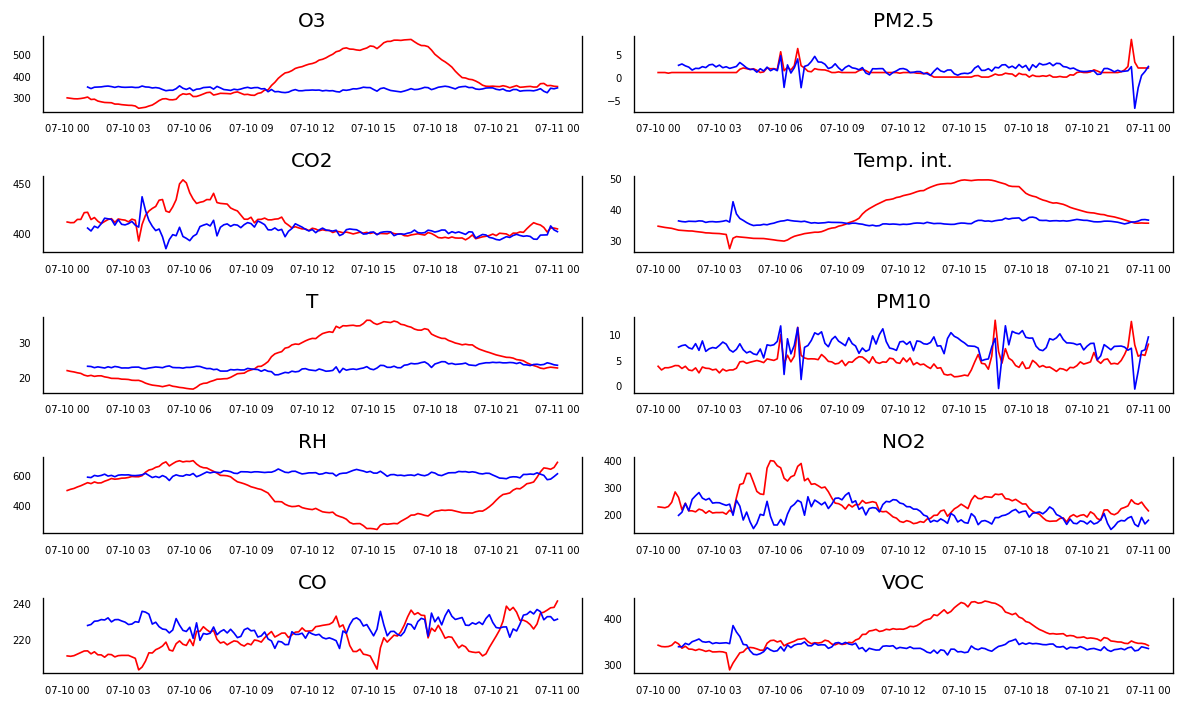

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Plot
fig, axes = plt.subplots(nrows=5, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data_2 = df_copy[df.columns[i]]
    data_res=res[res.columns[i]]
    ax.plot(data_2, color='red', linewidth=1)
    ax.plot(data_res, color='blue', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

Define a threshold: if the value is farther from the prediction than the mean ditance of the actual value from the prediction +10% of the prediction scale it is an anomaly

In [35]:
import numpy as np
#define threshold for all the columns
distance = pd.DataFrame()
threshold=[]
scale= []
mean=[]
usable = df_copy.iloc[selected_lag:, :]
for col in df.columns:
  distance[col]=(usable[col]).values-(res[col]).values
  mean.append(distance[col].mean())
  scale.append(usable[col].values.max()-usable[col].values.min())
for i in range(len(mean)):
  threshold.append(mean[i]+0.6*scale[i])
#find where the threshold is not respected
i=0
list_rows=[]
for col in df.columns:
  for j in range(len(usable)):
    if(abs((usable.iloc[[j],[i]].values-res.iloc[[j],[i]].values))>threshold[i]):
      list_rows.append(j)
  i=i+1
usable['Predictions']=0
index = usable.columns.get_loc('Predictions')
for i in range(len(list_rows)):
  usable.iloc[[list_rows[i]],[index]]=1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [36]:
usable.reset_index(drop=True, inplace=True)
res.reset_index(drop=True, inplace=True)
results_pred=pd.concat([usable, res], axis=1)
results_pred['Dates'] = df.index[selected_lag:]
# fix usable
usable['Dates']=df.index[selected_lag:]
usable=usable.set_index('Dates')
# fix res
res['Dates']=df.index[selected_lag:]
res=res.set_index('Dates')
#print results
results_pred=results_pred.set_index('Dates')
results_pred

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Predictions,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC
Dates,,,,,,,,,,,,,,,,,,,,,
2021-07-10 01:00:00,301.833333,1.000000,420.500000,33.298333,20.183333,3.833333,549.166667,260.833333,213.500000,343.666667,1,347.753062,2.590582,404.825047,36.271551,22.988508,7.438223,586.721187,194.211287,227.515377,337.462557
2021-07-10 01:10:00,290.714286,1.000000,413.285714,33.204286,20.371429,3.285714,542.714286,215.000000,211.857143,334.142857,1,340.742542,2.884033,401.926447,36.062685,22.923206,7.738517,583.950089,205.952047,228.059429,337.286082
2021-07-10 01:20:00,292.000000,1.000000,415.285714,33.090000,20.085714,3.714286,554.142857,239.428571,213.000000,338.428571,1,346.948670,2.467319,406.643404,35.955903,22.590609,7.877683,598.649569,238.313084,229.860543,344.803737
2021-07-10 01:30:00,283.666667,1.000000,411.666667,33.041667,20.233333,3.000000,546.833333,211.166667,211.333333,332.333333,1,347.453701,2.194532,405.032053,36.161569,22.819407,7.305372,593.817118,211.146195,230.024501,341.961098
2021-07-10 01:40:00,280.000000,1.000000,409.285714,33.022857,20.242857,2.857143,548.142857,211.000000,211.285714,331.857143,1,348.464101,1.540686,409.202336,36.132698,22.661131,7.082178,598.564096,253.595333,230.777439,348.415701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-10 23:20:00,364.285714,3.285714,405.428571,35.588571,22.300000,7.857143,650.000000,239.142857,234.857143,346.714286,1,328.269667,-6.874018,397.909972,35.937176,23.511733,-0.723533,599.164125,161.158218,230.654652,328.302727
2021-07-10 23:30:00,353.833333,2.000000,400.833333,35.540000,22.566667,5.666667,646.666667,235.166667,236.000000,344.833333,1,321.707331,-2.350238,398.075039,36.209755,23.991560,2.747115,569.603122,152.663836,232.368369,329.744413
2021-07-10 23:40:00,354.857143,2.000000,404.857143,35.608571,22.728571,6.000000,640.857143,243.428571,237.285714,344.857143,0,342.092884,0.354082,406.968343,36.651197,23.755308,6.665621,573.484897,186.746579,232.401661,337.277515


In [42]:
index_no = results_pred.columns.get_loc('Predictions')
i=0
while(i<len(results_pred)):
  if(results_pred.iloc[[i],[index_no]].values == 1):
    j=i+1
    while(results_pred.iloc[[j],[index_no]].values == 1):
      j=j+1
    for s in range(i,j):
      print(s)
      d=0
      for col in df.columns:
        dis=float(usable.iloc[[s],[d]].values-res.iloc[[s],[d]].values)
        print(col+':'+str(dis))
        d=d+1
    print ('*' * 20)
    if(i-3<0):
      tmp=results_pred.iloc[i: j + 2]
      display(tmp)
    if(j+2>len(results_pred)):
      tmp=results_pred.iloc[i: j + 2]
      display(tmp)
    else:
      tmp=results_pred.iloc[i - 3 : j + 2]
      display(tmp)
    i=j
  else:
    i=i+1    

0
O3:-45.91972835619737
PM2.5:-1.5905818298574061
CO2:15.674952888056907
Temp. int.:-2.97321804004833
T:-2.805174324349167
PM10:-3.6048899269135357
RH:-37.55452021185022
NO2:66.6220462486614
CO:-14.015376636292018
VOC:6.204110163647272
1
O3:-50.028256004730736
PM2.5:-1.884033278214158
CO2:11.359267567015138
Temp. int.:-2.858398903340145
T:-2.551777298457619
PM10:-4.45280289560778
RH:-41.23580376783491
NO2:9.047952985542906
CO:-16.20228599253622
VOC:-3.1432250842793223
2
O3:-54.94867045098209
PM2.5:-1.467319045235663
CO2:8.642310435141098
Temp. int.:-2.8659033819683373
T:-2.5048950216926826
PM10:-4.163397191250084
RH:-44.50671145034278
NO2:1.1154870939591603
CO:-16.860542817407236
VOC:-6.37516582279676
3
O3:-63.78703452040975
PM2.5:-1.1945317332514063
CO2:6.63461416639575
Temp. int.:-3.1199019901976257
T:-2.586073548211136
PM10:-4.305372289797125
RH:-46.983785119477716
NO2:0.02047201249345676
CO:-18.691167529236935
VOC:-9.627764730911053
4
O3:-68.46410074362046
PM2.5:-0.5406863526669925

,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Predictions,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC
Dates,,,,,,,,,,,,,,,,,,,,,
2021-07-10 01:00:00,301.833333,1.000000,420.500000,33.298333,20.183333,3.833333,549.166667,260.833333,213.500000,343.666667,1,347.753062,2.590582,404.825047,36.271551,22.988508,7.438223,586.721187,194.211287,227.515377,337.462557
2021-07-10 01:10:00,290.714286,1.000000,413.285714,33.204286,20.371429,3.285714,542.714286,215.000000,211.857143,334.142857,1,340.742542,2.884033,401.926447,36.062685,22.923206,7.738517,583.950089,205.952047,228.059429,337.286082
2021-07-10 01:20:00,292.000000,1.000000,415.285714,33.090000,20.085714,3.714286,554.142857,239.428571,213.000000,338.428571,1,346.948670,2.467319,406.643404,35.955903,22.590609,7.877683,598.649569,238.313084,229.860543,344.803737
2021-07-10 01:30:00,283.666667,1.000000,411.666667,33.041667,20.233333,3.000000,546.833333,211.166667,211.333333,332.333333,1,347.453701,2.194532,405.032053,36.161569,22.819407,7.305372,593.817118,211.146195,230.024501,341.961098
2021-07-10 01:40:00,280.000000,1.000000,409.285714,33.022857,20.242857,2.857143,548.142857,211.000000,211.285714,331.857143,1,348.464101,1.540686,409.202336,36.132698,22.661131,7.082178,598.564096,253.595333,230.777439,348.415701
2021-07-10 01:50:00,277.000000,1.000000,411.400000,32.860000,19.940000,3.400000,559.200000,207.200000,210.000000,329.400000,1,350.950134,1.926479,414.620248,36.086195,22.488045,8.112584,607.200118,267.034461,230.543213,351.139006
2021-07-10 02:00:00,276.285714,1.000000,413.285714,32.737143,19.771429,2.428571,567.285714,217.285714,211.571429,332.000000,1,352.226050,1.880292,414.002528,36.281023,22.843673,6.809006,594.218682,278.867335,231.727558,354.326583
2021-07-10 02:10:00,275.714286,1.000000,414.142857,32.610000,19.514286,3.571429,577.428571,213.285714,211.428571,330.000000,1,349.765062,2.295200,413.426064,36.223012,22.584546,8.646297,598.974313,258.133266,229.497671,348.538927
2021-07-10 02:20:00,269.666667,1.000000,410.500000,32.428333,19.483333,3.333333,572.833333,202.166667,210.166667,327.166667,1,346.144962,2.086701,407.679687,35.796267,22.933958,6.613123,589.852161,251.465679,230.708900,347.292960


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Predictions,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC
Dates,,,,,,,,,,,,,,,,,,,,,


21
O3:-57.17718667858725
PM2.5:-0.013425166438308489
CO2:28.60334442161559
Temp. int.:-4.409194643746574
T:-5.3864112094287435
PM10:-2.1022643949758137
RH:76.27785416120787
NO2:179.2502191572675
CO:-11.828776220277177
VOC:7.270666661584926
********************


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Predictions,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC
Dates,,,,,,,,,,,,,,,,,,,,,
2021-07-10 04:00:00,260.714286,1.714286,421.714286,31.098571,17.814286,4.571429,635.714286,308.714286,212.428571,324.000000,1,347.352562,3.207194,412.471478,37.060776,22.477689,8.090435,598.332672,228.462524,233.769171,359.688291
2021-07-10 04:10:00,265.333333,2.000000,424.333333,31.015000,17.566667,4.666667,641.000000,312.666667,212.333333,326.000000,0,343.511443,2.643964,406.617900,36.437403,22.619013,6.926470,584.343279,176.917720,228.278727,342.490164
2021-07-10 04:20:00,274.857143,1.857143,426.285714,30.898571,17.457143,4.285714,654.000000,349.571429,214.142857,334.000000,0,345.333579,2.023183,402.309651,35.729199,22.783238,6.320650,591.541631,206.517971,229.319441,341.379931
2021-07-10 04:30:00,285.666667,1.666667,432.500000,30.766667,17.316667,4.500000,660.333333,349.666667,215.000000,335.833333,1,342.843853,1.680092,403.896656,35.175861,22.703078,6.602264,584.055479,170.416448,226.828776,328.562667
2021-07-10 04:40:00,293.166667,1.833333,433.166667,30.655000,17.116667,4.666667,680.500000,317.333333,216.166667,335.000000,0,336.459349,1.722146,396.124830,34.783435,22.577390,6.125431,597.815976,145.231973,225.544034,320.847345
2021-07-10 04:50:00,294.333333,1.500000,421.666667,30.638333,17.333333,4.833333,691.166667,283.000000,218.333333,332.666667,0,330.833788,1.078871,384.348159,34.907745,22.929030,5.956578,587.067229,164.404045,225.261770,319.792283


27
O3:-44.81721825299286
PM2.5:0.4342369487842317
CO2:43.05082411573835
Temp. int.:-5.02310683687562
T:-5.6849398242592954
PM10:-2.743640596080917
RH:103.43869005988006
NO2:206.19868413444624
CO:-8.69382715471852
VOC:20.517335524080636
28
O3:-25.444039032702108
PM2.5:0.05394456368167999
CO2:56.24669533164189
Temp. int.:-5.382599499553052
T:-5.654269855884355
PM10:-3.045046816511526
RH:97.40727421693441
NO2:236.81811640738235
CO:-7.669988254506933
VOC:24.46057281156834
29
O3:-22.710036086286493
PM2.5:0.26203574791715045
CO2:55.03579441390491
Temp. int.:-5.93412507326855
T:-6.053896646051136
PM10:-3.380814889116283
RH:91.17865116234577
NO2:219.75870562890913
CO:-7.706586584174545
VOC:19.224846671192097
30
O3:-26.253815862162924
PM2.5:0.8757984323897166
CO2:47.54783636313914
Temp. int.:-6.313469045381531
T:-6.1727018111579035
PM10:-1.7071613925920133
RH:93.72300487907171
NO2:191.47546210230664
CO:-6.671109992953973
VOC:12.840578540765364
31
O3:-26.72349412361376
PM2.5:3.672459485532837
CO

,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Predictions,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC
Dates,,,,,,,,,,,,,,,,,,,,,
2021-07-10 05:00:00,289.666667,1.000000,420.500000,30.638333,17.566667,4.666667,663.500000,273.666667,214.000000,329.833333,0,333.181339,1.835163,393.396824,34.924443,23.086696,7.076067,564.026351,198.140436,223.391671,322.229107
2021-07-10 05:10:00,289.142857,1.142857,425.857143,30.600000,17.242857,4.428571,679.000000,271.714286,213.428571,329.857143,0,332.969015,1.338364,398.273428,35.171095,22.642200,5.330183,591.877304,194.331105,225.009410,326.531207
2021-07-10 05:20:00,291.857143,2.000000,433.000000,30.458571,17.100000,5.142857,692.428571,369.714286,217.428571,345.000000,0,340.113507,2.186356,397.228136,35.023524,22.590129,7.882586,602.681613,246.316886,231.317727,335.416755
2021-07-10 05:30:00,308.333333,1.833333,448.666667,30.320000,16.900000,5.000000,699.000000,397.166667,219.000000,350.833333,1,353.150552,1.399096,405.615843,35.343107,22.584940,7.743641,595.561310,190.967983,227.693827,330.315998
2021-07-10 05:40:00,316.714286,1.857143,452.714286,30.170000,16.800000,4.857143,690.857143,395.428571,217.142857,351.714286,1,342.158325,1.803198,396.467590,35.552599,22.454270,7.902190,593.449869,158.610455,224.812845,327.253713
2021-07-10 05:50:00,314.166667,1.666667,449.666667,29.995000,16.616667,5.166667,695.166667,378.166667,216.500000,347.833333,1,336.876703,1.404631,394.630872,35.929125,22.670563,8.547482,603.988016,158.407961,224.206587,328.608487
2021-07-10 06:00:00,317.285714,5.571429,439.857143,29.884286,16.485714,9.857143,693.857143,370.571429,219.857143,350.285714,1,343.539530,4.695630,392.309306,36.197755,22.658416,11.564304,600.134138,179.095966,226.528253,337.445136
2021-07-10 06:10:00,304.200000,1.400000,433.600000,29.780000,16.420000,4.200000,699.600000,332.000000,216.400000,339.400000,1,330.923494,-2.272459,396.673441,36.313111,22.774958,2.126486,611.839043,158.670988,220.411665,328.005312
2021-07-10 06:20:00,304.714286,2.142857,429.285714,30.138571,16.971429,5.857143,676.285714,321.428571,224.285714,343.857143,0,337.999880,2.684502,398.764569,36.586576,22.984621,9.066774,589.909958,198.849430,228.972973,341.341533


36
O3:-23.740542273539347
PM2.5:4.839677215983674
CO2:26.06666969287386
Temp. int.:-4.1404516660451485
T:-3.7640092703514085
PM10:4.693107660725219
RH:21.404068457903122
NO2:143.77277904990794
CO:0.5904851768024173
VOC:10.862244517172144
********************


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Predictions,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC
Dates,,,,,,,,,,,,,,,,,,,,,
2021-07-10 06:30:00,309.714286,1.571429,430.428571,30.808571,17.714286,4.571429,659.714286,337.000000,224.285714,346.714286,0,339.324094,0.892874,406.293667,36.372010,22.933078,6.124888,598.747368,225.433121,219.317998,335.386752
2021-07-10 06:40:00,315.833333,2.500000,431.166667,31.318333,18.066667,5.666667,651.333333,342.666667,226.833333,349.500000,0,345.253695,2.056306,407.716858,36.225540,22.598086,7.777233,610.219296,235.094547,223.092523,340.874169
2021-07-10 06:50:00,322.142857,6.285714,433.142857,31.624286,18.157143,11.285714,649.571429,376.000000,225.142857,353.571429,0,346.273328,3.999468,408.839316,36.148013,22.319151,11.238416,622.174202,249.866538,222.662298,343.187393
2021-07-10 07:00:00,323.833333,2.500000,433.000000,31.885000,18.583333,5.833333,637.333333,386.666667,223.833333,354.333333,1,347.573876,-2.339677,406.933330,36.025452,22.347343,1.140226,615.929265,242.893888,223.242848,343.471089
2021-07-10 07:10:00,311.000000,2.000000,439.333333,32.183333,18.883333,5.333333,626.666667,322.500000,224.833333,356.000000,0,338.284602,2.354240,412.554975,36.167308,22.024463,7.402182,621.556501,194.673688,226.677203,347.939255
2021-07-10 07:20:00,314.571429,1.285714,430.142857,32.342857,19.257143,5.142857,614.571429,331.428571,219.857143,348.714286,0,350.622428,2.620988,397.074262,35.885465,22.147182,7.748745,619.697865,263.329023,222.407775,339.832286


39
O3:-24.8699369190237
PM2.5:-2.2692387816775685
CO2:23.729347778125998
Temp. int.:-3.0835710806962666
T:-2.313515841863161
PM10:-3.5806942084179587
RH:-18.008017858380526
NO2:82.92002425670424
CO:-6.308750357638445
VOC:4.70568210049322
40
O3:-17.82957169421138
PM2.5:-2.700177220693615
CO2:20.93160680321256
Temp. int.:-3.059348782704106
T:-2.196697395265698
PM10:-5.078503064524052
RH:-32.36014790424804
NO2:60.50366209760281
CO:-6.7475127804501085
VOC:1.2606930106911705
41
O3:-16.698103791922392
PM2.5:-1.660223947160189
CO2:19.699277487555605
Temp. int.:-2.918332042994102
T:-2.185159937174756
PM10:-4.884722696764822
RH:-32.77121324574102
NO2:61.32747976665945
CO:-6.549931622626701
VOC:4.527820724897481
42
O3:-15.587395175115546
PM2.5:-1.679215805227508
CO2:18.236268657273115
Temp. int.:-2.825377923906146
T:-2.241402121381114
PM10:-4.417421836320171
RH:-34.81708298051467
NO2:62.63492484599692
CO:-7.426030541880834
VOC:5.014230952018465
********************


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Predictions,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC
Dates,,,,,,,,,,,,,,,,,,,,,
2021-07-10 07:00:00,323.833333,2.500000,433.000000,31.885000,18.583333,5.833333,637.333333,386.666667,223.833333,354.333333,1,347.573876,-2.339677,406.933330,36.025452,22.347343,1.140226,615.929265,242.893888,223.242848,343.471089
2021-07-10 07:10:00,311.000000,2.000000,439.333333,32.183333,18.883333,5.333333,626.666667,322.500000,224.833333,356.000000,0,338.284602,2.354240,412.554975,36.167308,22.024463,7.402182,621.556501,194.673688,226.677203,347.939255
2021-07-10 07:20:00,314.571429,1.285714,430.142857,32.342857,19.257143,5.142857,614.571429,331.428571,219.857143,348.714286,0,350.622428,2.620988,397.074262,35.885465,22.147182,7.748745,619.697865,263.329023,222.407775,339.832286
2021-07-10 07:30:00,319.000000,1.166667,429.333333,32.486667,19.300000,5.166667,599.000000,309.333333,217.833333,344.000000,1,343.869937,3.435905,405.603986,35.570238,21.613516,8.747361,617.008018,226.413309,224.142084,339.294318
2021-07-10 07:40:00,318.428571,1.857143,429.000000,32.638571,19.400000,5.142857,598.428571,311.571429,218.428571,346.142857,1,336.258143,4.557320,408.068393,35.697920,21.596697,10.221360,630.788719,251.067766,225.176084,344.882164
2021-07-10 07:50:00,317.833333,1.666667,428.666667,32.628333,19.433333,5.000000,596.166667,304.166667,216.833333,345.500000,1,334.531437,3.326891,408.967389,35.546665,21.618493,9.884723,628.937880,242.839187,223.383265,340.972179
2021-07-10 08:00:00,316.600000,1.600000,424.800000,32.806000,19.800000,6.000000,589.400000,296.000000,218.000000,346.800000,1,332.187395,3.279216,406.563731,35.631378,22.041402,10.417422,624.217083,233.365075,225.426031,341.785769
2021-07-10 08:10:00,322.714286,1.571429,423.142857,33.215714,20.328571,5.428571,571.000000,299.428571,219.000000,351.714286,0,337.808037,2.826776,408.253427,35.692168,21.935941,8.180060,613.889643,243.218743,223.343727,341.344905
2021-07-10 08:20:00,325.500000,1.333333,421.833333,33.690000,20.850000,4.666667,555.166667,282.000000,218.666667,349.833333,0,335.060424,1.882085,407.751446,35.881932,22.046244,7.513673,611.705959,219.578983,220.808837,333.846896


45
O3:-19.280646361864513
PM2.5:-1.1451200462230497
CO2:12.499601996381443
Temp. int.:-1.8317891047710333
T:-0.982717299460429
PM10:-4.351444096857659
RH:-75.08141464622975
NO2:23.399972303705653
CO:-4.469112338405836
VOC:6.353218369105605
46
O3:-30.42498875353334
PM2.5:-1.925326180794662
CO2:5.416617761504483
Temp. int.:-1.6909385060459527
T:-0.9178942475900733
PM10:-5.353303932732353
RH:-82.2380790771532
NO2:-17.767893523885874
CO:-9.019087783279048
VOC:-3.7335616497877595
47
O3:-32.15228889725404
PM2.5:-0.8871598288079197
CO2:3.341829893998863
Temp. int.:-1.1929664970987162
T:-0.7618415638996936
PM10:-4.321861539072315
RH:-90.52489479424457
NO2:-21.109258270919184
CO:-8.472754973174403
VOC:-1.763666277182324
********************


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Predictions,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC
Dates,,,,,,,,,,,,,,,,,,,,,
2021-07-10 08:00:00,316.600000,1.600000,424.800000,32.806000,19.800000,6.000000,589.400000,296.000000,218.000000,346.800000,1,332.187395,3.279216,406.563731,35.631378,22.041402,10.417422,624.217083,233.365075,225.426031,341.785769
2021-07-10 08:10:00,322.714286,1.571429,423.142857,33.215714,20.328571,5.428571,571.000000,299.428571,219.000000,351.714286,0,337.808037,2.826776,408.253427,35.692168,21.935941,8.180060,613.889643,243.218743,223.343727,341.344905
2021-07-10 08:20:00,325.500000,1.333333,421.833333,33.690000,20.850000,4.666667,555.166667,282.000000,218.666667,349.833333,0,335.060424,1.882085,407.751446,35.881932,22.046244,7.513673,611.705959,219.578983,220.808837,333.846896
2021-07-10 08:30:00,319.285714,1.000000,417.714286,33.965714,20.942857,4.571429,548.857143,258.714286,217.000000,343.285714,1,338.566361,2.145120,405.214684,35.797503,21.925574,8.922873,623.938558,235.314313,221.469112,336.932496
2021-07-10 08:40:00,313.000000,1.000000,413.666667,34.106667,21.016667,4.166667,541.500000,239.666667,216.166667,341.666667,1,343.424989,2.925326,408.250049,35.797605,21.934561,9.519971,623.738079,257.434560,225.185754,345.400228
2021-07-10 08:50:00,314.285714,1.142857,413.571429,34.577143,21.614286,4.285714,532.428571,237.571429,217.571429,344.857143,1,346.438003,2.030017,410.229599,35.770109,22.376127,8.607576,622.953466,258.680687,226.044184,346.620809
2021-07-10 09:00:00,310.571429,1.000000,415.571429,34.825714,21.942857,4.857143,521.285714,230.857143,216.857143,342.428571,0,342.188972,1.407380,409.278511,35.725398,22.220664,8.180114,619.567121,251.896149,224.564610,343.286376
2021-07-10 09:10:00,309.666667,1.000000,410.000000,35.180000,22.216667,3.833333,515.000000,217.500000,219.500000,343.500000,1,344.994486,2.132128,405.816847,35.546524,22.118178,7.716508,623.460255,268.740869,224.828394,346.907243


49
O3:-35.32781926808855
PM2.5:-1.1321275877143453
CO2:4.183153010474712
Temp. int.:-0.3665241508528112
T:0.09848859850852776
PM10:-3.8831743456423813
RH:-108.46025487729776
NO2:-51.240869280854554
CO:-5.328393556491051
VOC:-3.4072425225174356
50
O3:-26.809634110445927
PM2.5:-1.5392883457515656
CO2:1.56824041567819
Temp. int.:0.3886999749473361
T:0.891247366152168
PM10:-4.7012310382673785
RH:-115.65801908145357
NO2:-43.85153726103809
CO:-2.0025616924839085
VOC:3.4639771017998555
51
O3:-17.36607040132327
PM2.5:-1.038599854468476
CO2:3.267285811213185
Temp. int.:0.5010469876120638
T:1.4402576853841111
PM10:-3.6190613306814505
RH:-118.65690799536941
NO2:-15.993788915550795
CO:-3.4142471283270766
VOC:4.226891989887747
********************


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Predictions,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC
Dates,,,,,,,,,,,,,,,,,,,,,
2021-07-10 08:40:00,313.000000,1.000000,413.666667,34.106667,21.016667,4.166667,541.500000,239.666667,216.166667,341.666667,1,343.424989,2.925326,408.250049,35.797605,21.934561,9.519971,623.738079,257.434560,225.185754,345.400228
2021-07-10 08:50:00,314.285714,1.142857,413.571429,34.577143,21.614286,4.285714,532.428571,237.571429,217.571429,344.857143,1,346.438003,2.030017,410.229599,35.770109,22.376127,8.607576,622.953466,258.680687,226.044184,346.620809
2021-07-10 09:00:00,310.571429,1.000000,415.571429,34.825714,21.942857,4.857143,521.285714,230.857143,216.857143,342.428571,0,342.188972,1.407380,409.278511,35.725398,22.220664,8.180114,619.567121,251.896149,224.564610,343.286376
2021-07-10 09:10:00,309.666667,1.000000,410.000000,35.180000,22.216667,3.833333,515.000000,217.500000,219.500000,343.500000,1,344.994486,2.132128,405.816847,35.546524,22.118178,7.716508,623.460255,268.740869,224.828394,346.907243
2021-07-10 09:20:00,318.571429,1.000000,413.428571,35.702857,22.942857,4.571429,507.714286,234.571429,219.142857,347.000000,1,345.381063,2.539288,411.860331,35.314157,22.051610,9.272660,623.372305,278.422966,221.145419,343.536023
2021-07-10 09:30:00,321.833333,1.000000,413.500000,36.038333,22.983333,4.500000,502.666667,225.333333,218.333333,346.000000,1,339.199404,2.038600,410.232714,35.537286,21.543076,8.119061,621.323575,241.327122,221.747580,341.773108
2021-07-10 09:40:00,334.000000,1.000000,414.714286,36.481429,23.585714,5.142857,490.428571,234.285714,220.714286,352.142857,0,340.293105,1.896168,408.196534,35.527184,21.992517,7.656410,618.669416,248.288581,223.922853,344.946641
2021-07-10 09:50:00,334.428571,1.428571,413.000000,37.121429,24.328571,5.571429,478.428571,233.428571,222.571429,355.000000,1,326.277982,1.611873,403.089888,35.330243,21.552420,6.234508,620.898057,216.669956,220.082002,332.828655


53
O3:8.150589013516878
PM2.5:-0.1833013601426583
CO2:9.91011195643398
Temp. int.:1.7911854908243043
T:2.7761515140725166
PM10:-0.6630790786738627
RH:-142.46948603576277
NO2:16.75861544529758
CO:2.4894269499196184
VOC:22.17134485626866
54
O3:18.47311343828767
PM2.5:-0.4186887950406428
CO2:10.019235341337378
Temp. int.:3.2783394838156354
T:4.304771715783275
PM10:-1.7651573155980422
RH:-171.94469809225865
NO2:24.659483531689034
CO:5.169054582294052
VOC:28.861491563041284
55
O3:43.19230121664799
PM2.5:0.515847328212991
CO2:8.77928435888822
Temp. int.:4.5687399281072345
T:6.0292888714260044
PM10:-1.6069442932380111
RH:-209.38356811787725
NO2:43.633485793430765
CO:6.261208301551079
VOC:37.827910434107594
56
O3:60.54396848081052
PM2.5:0.4426114474513636
CO2:11.507619667362746
Temp. int.:5.480221083489596
T:6.368926524103863
PM10:-2.602000320784903
RH:-222.6354416599571
NO2:22.44142307065769
CO:3.388460233198913
VOC:37.86694841344212
57
O3:77.26303219823939
PM2.5:-0.83835117678947
CO2:12.1822

,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Predictions,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC
Dates,,,,,,,,,,,,,,,,,,,,,
2021-07-10 09:20:00,318.571429,1.000000,413.428571,35.702857,22.942857,4.571429,507.714286,234.571429,219.142857,347.000000,1,345.381063,2.539288,411.860331,35.314157,22.051610,9.272660,623.372305,278.422966,221.145419,343.536023
2021-07-10 09:30:00,321.833333,1.000000,413.500000,36.038333,22.983333,4.500000,502.666667,225.333333,218.333333,346.000000,1,339.199404,2.038600,410.232714,35.537286,21.543076,8.119061,621.323575,241.327122,221.747580,341.773108
2021-07-10 09:40:00,334.000000,1.000000,414.714286,36.481429,23.585714,5.142857,490.428571,234.285714,220.714286,352.142857,0,340.293105,1.896168,408.196534,35.527184,21.992517,7.656410,618.669416,248.288581,223.922853,344.946641
2021-07-10 09:50:00,334.428571,1.428571,413.000000,37.121429,24.328571,5.571429,478.428571,233.428571,222.571429,355.000000,1,326.277982,1.611873,403.089888,35.330243,21.552420,6.234508,620.898057,216.669956,220.082002,332.828655
2021-07-10 10:00:00,354.833333,1.666667,413.000000,38.486667,25.750000,5.500000,448.833333,249.500000,224.166667,364.333333,1,336.360220,2.085355,402.980765,35.208327,21.445228,7.265157,620.778031,224.840516,218.997612,335.471842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-10 20:50:00,351.714286,1.000000,398.857143,39.342857,26.614286,4.142857,404.857143,196.714286,218.571429,359.000000,1,343.804931,1.214969,394.873596,36.462358,24.139050,6.892232,601.482425,171.221028,229.192900,334.724314
2021-07-10 21:00:00,350.333333,1.000000,397.333333,39.046667,26.266667,4.333333,429.333333,188.000000,221.666667,355.666667,1,337.540264,1.240149,393.490155,36.445974,24.045461,7.628625,591.461956,162.296621,226.386688,330.575931
2021-07-10 21:10:00,349.571429,1.142857,399.714286,38.900000,26.042857,4.571429,451.428571,207.428571,225.000000,356.714286,1,334.653815,1.370762,392.913721,36.215639,24.114771,8.146896,580.529192,173.699646,226.061198,332.805154


129
O3:17.9382749170382
PM2.5:-0.5021503004032644
CO2:7.0351191728590265
Temp. int.:1.4164693211420172
T:0.6142538621914078
PM10:-3.466846116393313
RH:-63.55960936622159
NO2:34.13117150825008
CO:-4.093240380124541
VOC:15.970587655150496
********************


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Predictions,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC
Dates,,,,,,,,,,,,,,,,,,,,,
2021-07-10 22:00:00,354.285714,1.000000,399.714286,37.922857,24.914286,5.142857,509.571429,214.714286,234.857143,355.714286,0,336.351890,1.889583,398.624343,36.199604,23.767077,7.433515,588.451646,164.510356,224.461924,330.110370
2021-07-10 22:10:00,346.666667,1.000000,401.000000,37.733333,24.783333,4.166667,507.166667,200.833333,230.333333,350.000000,0,328.687507,1.585966,397.482580,36.143797,24.068920,6.918174,582.137320,141.856043,228.336111,327.232620
2021-07-10 22:20:00,347.857143,1.000000,400.571429,37.542857,24.571429,4.285714,522.714286,196.571429,230.428571,349.142857,0,331.003947,1.152856,396.656962,36.010344,23.436472,7.581450,605.297894,153.526680,233.224176,330.981398
2021-07-10 22:30:00,349.571429,1.000000,404.142857,37.262857,24.000000,4.142857,541.857143,203.428571,229.571429,347.857143,1,331.633154,1.502150,397.107738,35.846388,23.385746,7.609703,605.416752,169.297400,233.664669,331.886555
2021-07-10 22:40:00,350.666667,1.166667,407.333333,36.946667,23.566667,4.833333,546.500000,219.166667,228.000000,347.666667,0,331.699489,1.205263,396.515982,35.582145,23.190664,7.647323,608.180787,175.359352,235.293851,333.481335
2021-07-10 22:50:00,347.714286,1.571429,410.142857,36.600000,23.200000,6.000000,553.857143,223.571429,225.571429,345.000000,0,330.304854,1.295262,393.876321,35.298060,23.507746,7.444209,605.939962,173.493347,233.876239,330.771385


133
O3:22.830649843537685
PM2.5:5.98539043498363
CO2:10.030075425590951
Temp. int.:-0.011457731602355636
T:-0.9327541435753126
PM10:5.2011135994427775
RH:15.678576020472406
NO2:62.4847489472499
CO:-0.887134288906168
VOC:13.301415475978388
134
O3:36.01604768376154
PM2.5:10.159732129121373
CO2:7.518598941915002
Temp. int.:-0.3486045666843154
T:-1.2117334645515534
PM10:8.580675820357087
RH:50.83587455628401
NO2:77.98463959458584
CO:4.202490811140478
VOC:18.411558313730097
135
O3:32.12600240522255
PM2.5:4.350237798638952
CO2:2.7582944563949354
Temp. int.:-0.6697548402890519
T:-1.4248933443379634
PM10:2.91955135550782
RH:77.06354491947138
NO2:82.50283049409418
CO:3.6316313953253427
VOC:15.088920713718665
********************


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Predictions,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC
Dates,,,,,,,,,,,,,,,,,,,,,
2021-07-10 22:40:00,350.666667,1.166667,407.333333,36.946667,23.566667,4.833333,546.500000,219.166667,228.000000,347.666667,0,331.699489,1.205263,396.515982,35.582145,23.190664,7.647323,608.180787,175.359352,235.293851,333.481335
2021-07-10 22:50:00,347.714286,1.571429,410.142857,36.600000,23.200000,6.000000,553.857143,223.571429,225.571429,345.000000,0,330.304854,1.295262,393.876321,35.298060,23.507746,7.444209,605.939962,173.493347,233.876239,330.771385
2021-07-10 23:00:00,347.833333,2.333333,408.833333,36.250000,22.900000,7.500000,585.833333,229.333333,228.333333,344.333333,0,334.139796,1.381195,393.684133,35.548630,23.575565,6.841256,616.488291,184.420317,236.327798,335.052392
2021-07-10 23:10:00,363.000000,8.285714,407.857143,35.900000,22.457143,12.428571,623.000000,252.285714,234.285714,350.000000,1,340.169350,2.300324,397.827067,35.911458,23.389897,7.227458,607.321424,189.800965,235.172849,336.698585
2021-07-10 23:20:00,364.285714,3.285714,405.428571,35.588571,22.300000,7.857143,650.000000,239.142857,234.857143,346.714286,1,328.269667,-6.874018,397.909972,35.937176,23.511733,-0.723533,599.164125,161.158218,230.654652,328.302727
2021-07-10 23:30:00,353.833333,2.000000,400.833333,35.540000,22.566667,5.666667,646.666667,235.166667,236.000000,344.833333,1,321.707331,-2.350238,398.075039,36.209755,23.991560,2.747115,569.603122,152.663836,232.368369,329.744413
2021-07-10 23:40:00,354.857143,2.000000,404.857143,35.608571,22.728571,6.000000,640.857143,243.428571,237.285714,344.857143,0,342.092884,0.354082,406.968343,36.651197,23.755308,6.665621,573.484897,186.746579,232.401661,337.277515
2021-07-10 23:50:00,351.333333,2.000000,404.833333,35.545000,22.616667,5.833333,653.166667,225.833333,237.500000,343.500000,0,339.681736,1.222704,402.984707,36.706537,23.413003,6.913452,590.770246,162.316320,230.287408,335.494722


# Get and prepare the data

,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC
Dates,,,,,,,,,,
2021-07-10 00:00:00,298.142857,1.000000,410.857143,34.572857,21.742857,3.714286,495.714286,225.714286,210.714286,340.714286
2021-07-10 00:10:00,295.833333,1.000000,410.166667,34.373333,21.516667,3.000000,504.000000,224.333333,210.500000,337.833333
2021-07-10 00:20:00,294.000000,1.000000,410.285714,34.170000,21.357143,3.428571,509.857143,222.428571,210.857143,337.285714
2021-07-10 00:30:00,293.571429,0.857143,413.428571,34.021429,21.114286,3.428571,520.000000,227.000000,211.714286,337.857143
2021-07-10 00:40:00,295.200000,1.000000,413.400000,33.876000,20.940000,3.600000,528.200000,242.800000,212.600000,340.600000
...,...,...,...,...,...,...,...,...,...,...
2021-07-10 23:20:00,364.285714,3.285714,405.428571,35.588571,22.300000,7.857143,650.000000,239.142857,234.857143,346.714286
2021-07-10 23:30:00,353.833333,2.000000,400.833333,35.540000,22.566667,5.666667,646.666667,235.166667,236.000000,344.833333
2021-07-10 23:40:00,354.857143,2.000000,404.857143,35.608571,22.728571,6.000000,640.857143,243.428571,237.285714,344.857143


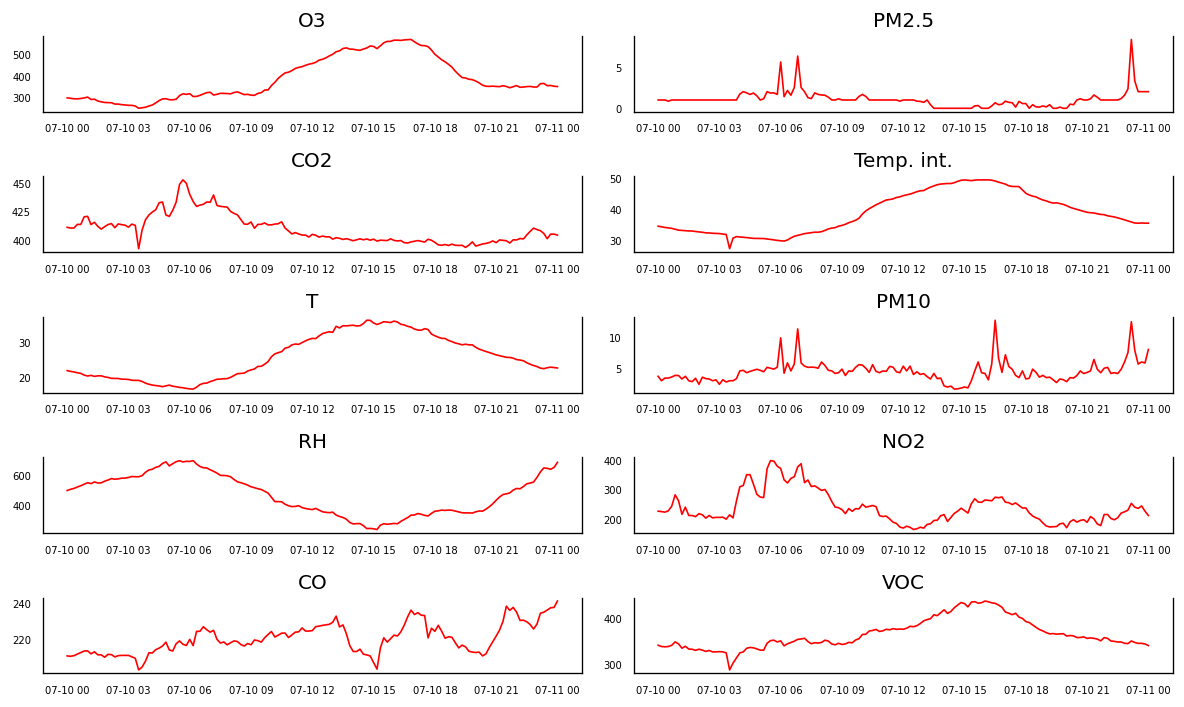

In [ ]:
import pandas as pd
import psycopg2
import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import numpy as np
%matplotlib inline


conn = psycopg2.connect(host='playground.magentalab.it', port='55432', database='airqino', user='datareader', password='homntLZnlhQd9prtVA9SFezQek')

query=""" select time_bucket('10 minutes', c."Dates" ) as "bucket", avg(c."O3") as "O3" ,  avg(c."PM2.5") as "PM2.5", avg(c."CO2") as "CO2",
 avg(c."Temp. int.") as "Temp. int.",  avg(c."T") as "T",  avg(c."PM10") as "PM10", avg(c."RH") as "RH", avg(c."NO2") as 
 "NO2", avg(c."CO") as "CO", avg(c."VOC") as "VOC"
from (select * from crosstab(
  'select sd.data_acquired as timestamp, s.sensor_type ,  sd.float_value as value 
from station_data sd join sensor s on s.id = sd.sensor_id
where sd.data_acquired >= to_timestamp(''2021-07-10 00:00:00'', ''YYYY-mm-dd HH24:MI:SS'')
 and sd.data_acquired <= to_timestamp(''2021-07-11 00:00:00'', ''YYYY-mm-dd HH24:MI:SS'')
and sd.station_id = 23284701 order by sd.data_acquired asc, 1'
 , $$VALUES ('O3'::varchar), ('PM2.5'::varchar), ('CO2'::varchar), ('Temp. int.'::varchar), ('T'::varchar)
 , ('PM10'::varchar), ('RH'::varchar), ('NO2'::varchar), ('CO'::varchar), ('VOC'::varchar)$$
) AS value ("Dates" timestamp, "O3" float, "PM2.5" float, "CO2" float, "Temp. int." float, "T" float, "PM10" float,
"RH" float, "NO2" float, "CO" float, "VOC" float))  c 
group by bucket
order by bucket asc;
 """
df_f = pd.read_sql(query, conn)
df_f= df_f.rename(columns={'bucket': 'Dates'})
df_f=df_f.set_index('Dates')
#fix temp int
df_f['Temp. int.'] = df_f['Temp. int.'].div(100)
df_f['T'] = df_f['T'].div(10)

display(df_f)

# Plot
fig, axes = plt.subplots(nrows=5, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df_f[df_f.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df_f.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

Splitting the series into train and testing data

In [ ]:
nobs = 4
df_train, df_test = df_f[0:-nobs], df_f[-nobs:]

# Check size
print(df_train.shape)  
print(df_test.shape)  

(141, 10)
(4, 10)


# Testing stationarity 

In [ ]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(ts_data, column='', signif=0.05, series=False):
    if series:
        adf_test = adfuller(ts_data, autolag='AIC')
    else:
        adf_test = adfuller(ts_data[column], autolag='AIC')
    p_value = adf_test[1]                   
    if p_value <= signif:
        test_result = "Stationary"
    else:
        test_result = "Non-Stationary"
    return test_result

adf_test_results = {
    col: test_stationarity(df_train, col)
    for col in df_train.columns
}
adf_test_results  

{'CO': 'Non-Stationary',
 'CO2': 'Non-Stationary',
 'NO2': 'Non-Stationary',
 'O3': 'Non-Stationary',
 'PM10': 'Non-Stationary',
 'PM2.5': 'Non-Stationary',
 'RH': 'Non-Stationary',
 'T': 'Non-Stationary',
 'Temp. int.': 'Non-Stationary',
 'VOC': 'Non-Stationary'}

First differencing

In [ ]:
df_differenced = df_train.diff().dropna()


In [ ]:
adf_test_results = {
    col: test_stationarity(df_differenced, col)
    for col in df_differenced.columns
}
adf_test_results 

{'CO': 'Stationary',
 'CO2': 'Stationary',
 'NO2': 'Non-Stationary',
 'O3': 'Non-Stationary',
 'PM10': 'Stationary',
 'PM2.5': 'Stationary',
 'RH': 'Non-Stationary',
 'T': 'Non-Stationary',
 'Temp. int.': 'Non-Stationary',
 'VOC': 'Stationary'}

Second differencing

In [ ]:
df_differenced = df_differenced.diff().dropna()


In [ ]:
adf_test_results = {
    col: test_stationarity(df_differenced, col)
    for col in df_differenced.columns
}
adf_test_results 

{'CO': 'Stationary',
 'CO2': 'Stationary',
 'NO2': 'Stationary',
 'O3': 'Stationary',
 'PM10': 'Stationary',
 'PM2.5': 'Stationary',
 'RH': 'Stationary',
 'T': 'Stationary',
 'Temp. int.': 'Stationary',
 'VOC': 'Stationary'}

# Forecasting VAR model

Selecting lag

In [ ]:
from statsmodels.tsa.api import VAR

model = VAR(df_differenced)
order = model.select_order(maxlags=5)
lag = order.aic
print(lag)


5


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  % freq, ValueWarning)


In [ ]:
model_fitted = model.fit(lag)

In [ ]:
# Input data for forecasting
forecast_input = df_differenced.values[-lag:]
forecast_input

array([[-6.19047619e-01,  1.66666667e-01, -3.80952381e-01,
        -3.61904762e-02,  1.38095238e-01,  8.33333333e-01,
        -1.45000000e+01,  8.88095238e+00, -7.14285714e-01,
         1.09523810e+00],
       [-4.04761905e+00,  2.38095238e-01, -3.80952381e-01,
        -3.04761905e-02,  6.66666667e-02,  4.76190476e-01,
         2.71428571e+00, -1.13333333e+01, -8.57142857e-01,
        -2.47619048e+00],
       [ 3.07142857e+00,  3.57142857e-01, -4.11904762e+00,
        -3.33333333e-03,  6.66666667e-02,  3.33333333e-01,
         2.46190476e+01,  1.35714286e+00,  5.19047619e+00,
         2.00000000e+00],
       [ 1.50476190e+01,  5.19047619e+00,  3.33333333e-01,
         0.00000000e+00, -1.42857143e-01,  3.42857143e+00,
         5.19047619e+00,  1.71904762e+01,  3.19047619e+00,
         6.33333333e+00],
       [-1.38809524e+01, -1.09523810e+01, -1.45238095e+00,
         3.85714286e-02,  2.85714286e-01, -9.50000000e+00,
        -1.01666667e+01, -3.60952381e+01, -5.38095238e+00,
        -8.

In [ ]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=len(df)-lag)
df_forecast = pd.DataFrame(fc, index=df.index[-(len(df)-lag):], columns=df.columns + '_2d')
df_forecast

,O3_2d,PM2.5_2d,CO2_2d,Temp. int._2d,T_2d,PM10_2d,RH_2d,NO2_2d,CO_2d,VOC_2d
Dates,,,,,,,,,,
2021-07-10 00:50:00,-4.260101,6.262633,4.968712,-0.303598,0.590689,7.269459,-25.428956,-47.312878,3.473686,1.611526
2021-07-10 01:00:00,10.128734,-1.170820,-14.896592,0.010653,-0.321731,-3.606615,16.434063,72.947046,-6.159943,-4.262535
2021-07-10 01:10:00,1.828757,1.056204,10.670243,0.430973,-0.014015,2.197245,-10.702677,-21.718672,2.613268,3.495598
2021-07-10 01:20:00,-8.745573,1.576211,2.813306,0.024031,-0.696825,1.791421,13.891010,7.557475,-2.649820,2.014618
2021-07-10 01:30:00,-1.420956,-4.888893,-1.659071,-0.636514,0.377337,-6.112103,0.459769,10.004293,2.937126,-2.726056
...,...,...,...,...,...,...,...,...,...,...
2021-07-10 23:20:00,0.019580,0.004085,-0.015394,-0.001027,0.001101,0.004985,0.060733,-0.056567,-0.000105,-0.008215
2021-07-10 23:30:00,0.020171,0.004216,-0.015934,-0.001076,0.001136,0.004918,0.063403,-0.053907,0.000987,-0.007449
2021-07-10 23:40:00,0.021571,0.004336,-0.016340,-0.001051,0.001141,0.004897,0.063431,-0.052486,0.000875,-0.007395


In [ ]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc
df_results = invert_transformation(df_train, df_forecast, second_diff=True)        
df_results=df_results.loc[:, ['O3_forecast', 'PM2.5_forecast', 'CO2_forecast', 'Temp. int._forecast',
                   'T_forecast', 'PM10_forecast', 'RH_forecast', 'NO2_forecast','CO2_forecast','VOC_forecast']]
display(df_results)

,O3_forecast,PM2.5_forecast,CO2_forecast,Temp. int._forecast,T_forecast,PM10_forecast,RH_forecast,NO2_forecast,CO2_forecast,VOC_forecast
Dates,,,,,,,,,,
2021-07-10 00:50:00,361.311327,4.548348,407.968712,34.973545,22.733547,10.555173,651.571044,178.687122,407.968712,345.040097
2021-07-10 01:00:00,368.465674,4.640161,395.612261,34.369172,22.845362,9.646589,669.576150,191.178433,395.612261,339.103373
2021-07-10 01:10:00,377.448779,5.788178,393.926054,34.195771,22.943163,10.935250,676.878579,181.951071,393.926054,336.662247
2021-07-10 01:20:00,377.686310,8.512406,395.053152,34.046402,22.344138,14.015330,698.072018,180.281185,395.053152,336.235739
2021-07-10 01:30:00,376.502886,6.347740,394.521180,33.260519,22.122451,10.983309,719.725227,188.615592,394.521180,333.083175
...,...,...,...,...,...,...,...,...,...,...
2021-07-10 23:20:00,1021.718065,117.298702,-1.026270,-28.292825,21.582768,148.861211,3547.108884,-1161.048618,-1.026270,60.939431
2021-07-10 23:30:00,1027.980347,118.417294,-5.090416,-28.832593,21.650741,150.225698,3572.806317,-1174.858319,-5.090416,58.327363
2021-07-10 23:40:00,1034.264200,119.540222,-9.170902,-29.373413,21.719855,151.595082,3598.567182,-1188.720507,-9.170902,55.707899


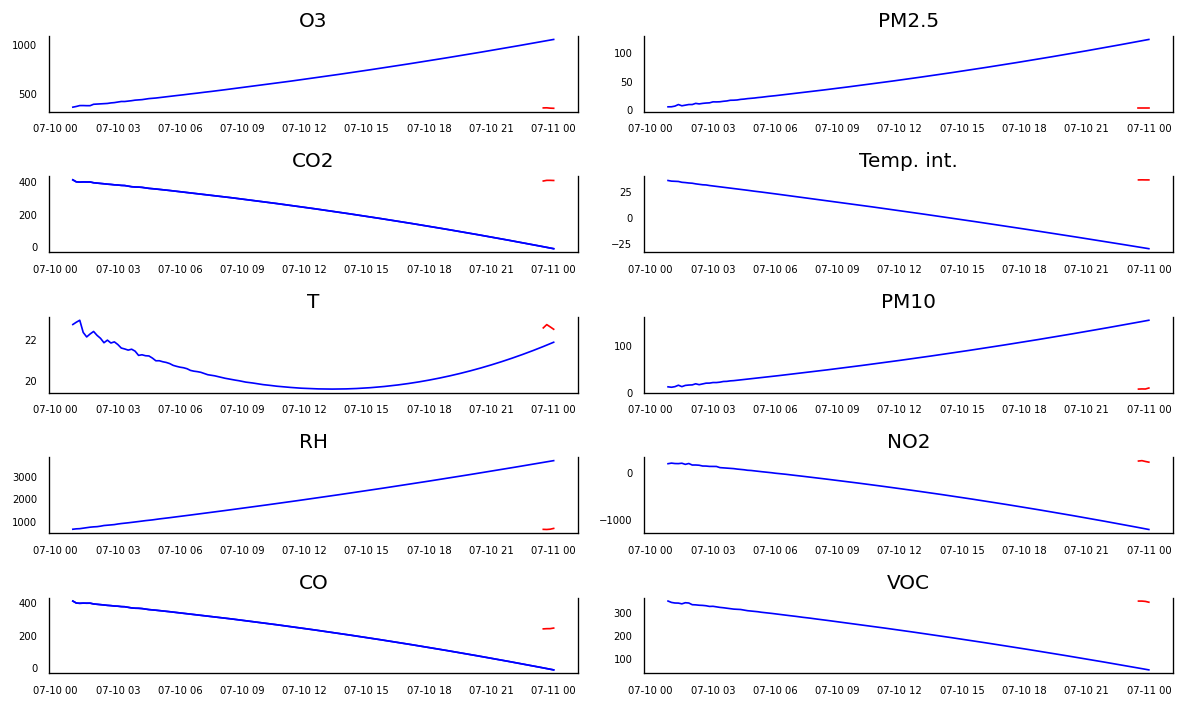

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Plot
fig, axes = plt.subplots(nrows=5, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data_3 = df_test[df_test.columns[i]]
    data_fc=df_results[df_results.columns[i]]
    ax.plot(data_3, color='red', linewidth=1)
    ax.plot(data_fc, color='blue', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();